## Import dataset

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [43]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/customer-churn.csv')

In [44]:
df.dtypes

Account_Length             int64
Voicemail_Message          int64
Day_Minutes              float64
Evening_Minutes          float64
Night_Minutes            float64
International_Minutes    float64
CustomerService_Calls      int64
Churn                     object
International_Plan        object
Voicemail_Plan            object
Day_Calls                  int64
Day_Charge               float64
Evening_Calls              int64
Evening_Charge           float64
Night_Calls                int64
Night_Charge             float64
International_Calls        int64
International_Charge     float64
State                     object
Area_Code                  int64
Phone                     object
dtype: object

The object type columns are
* International_Plan
* Voicemail_Plan
* State
* Phone
* Churn (Our target label) 

## EDA and Data preprocessing

In [45]:
df['Churn'].value_counts()

no     2137
yes     362
Name: Churn, dtype: int64

The dataset is imbalanced. The number of customers who don't churn is 6 times more than the customer who churn.

So, evaluation metric `f1_score` should be used. 


In [46]:
def cat_to_numeric(col):
  df[col]=df[col].map({'yes':1, 'no':0})
  return df[col]


The target column `Churn` along with the column `International_Plan` and `Voicemail_Plan` is converted to numeric column by yes=1 and no=0.

In [47]:
df['International_Plan'] = cat_to_numeric('International_Plan')
df['Voicemail_Plan'] = cat_to_numeric('Voicemail_Plan')
df['Churn'] = cat_to_numeric('Churn')

In [48]:
df.dtypes

Account_Length             int64
Voicemail_Message          int64
Day_Minutes              float64
Evening_Minutes          float64
Night_Minutes            float64
International_Minutes    float64
CustomerService_Calls      int64
Churn                      int64
International_Plan         int64
Voicemail_Plan             int64
Day_Calls                  int64
Day_Charge               float64
Evening_Calls              int64
Evening_Charge           float64
Night_Calls                int64
Night_Charge             float64
International_Calls        int64
International_Charge     float64
State                     object
Area_Code                  int64
Phone                     object
dtype: object

Column `State` and `Phone` are dropped because there are 50 states for which label encoding would result 50 labels while phone number can be combination of any 7 numbers.

In [49]:
df.drop(columns=['State','Phone'],inplace=True)

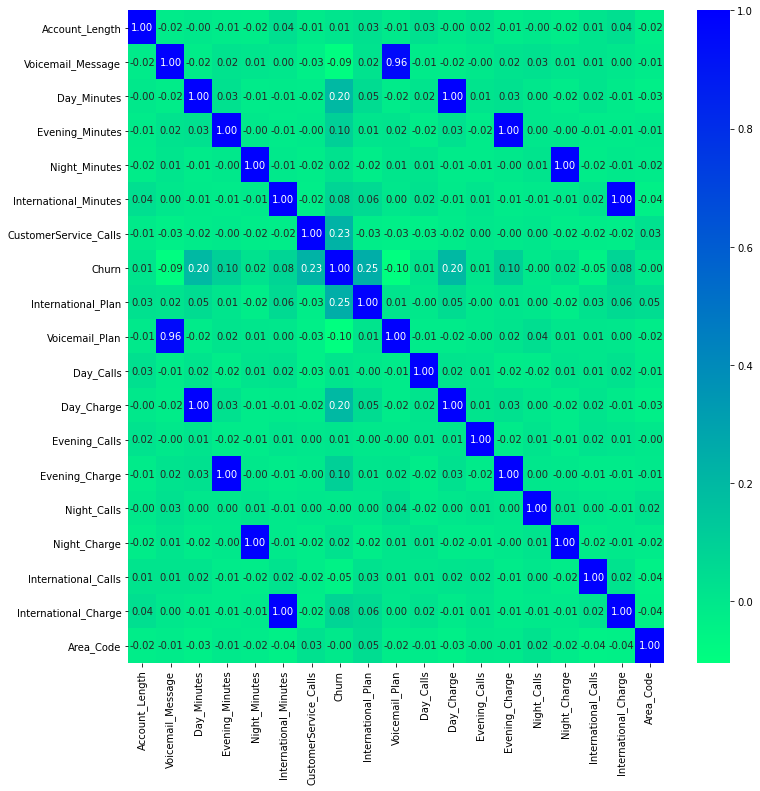

In [50]:
plt.figure(figsize=(12,12))
fig=sns.heatmap(df.corr(),annot=True, fmt='.2f',cmap='winter_r')
plt.show()

We can see `Voicemail_Message` is highly correlated to `Voicemail_Plan`, `Day_Minutes` is related to `Day_Charge`, `Evening_Minutes` is related to `Evening_Charge` and  `International_Minutes` is related to `International_Charge`. We may have to drop these columns because each pair is equally correlated to the target label.

In [51]:
df.drop(columns=['Voicemail_Plan','Day_Charge', 'Evening_Charge', 'Night_Charge','International_Charge'],inplace=True)

In [52]:
df['Area_Code'].value_counts()

415    1261
510     623
408     615
Name: Area_Code, dtype: int64

There are only three area codes. 

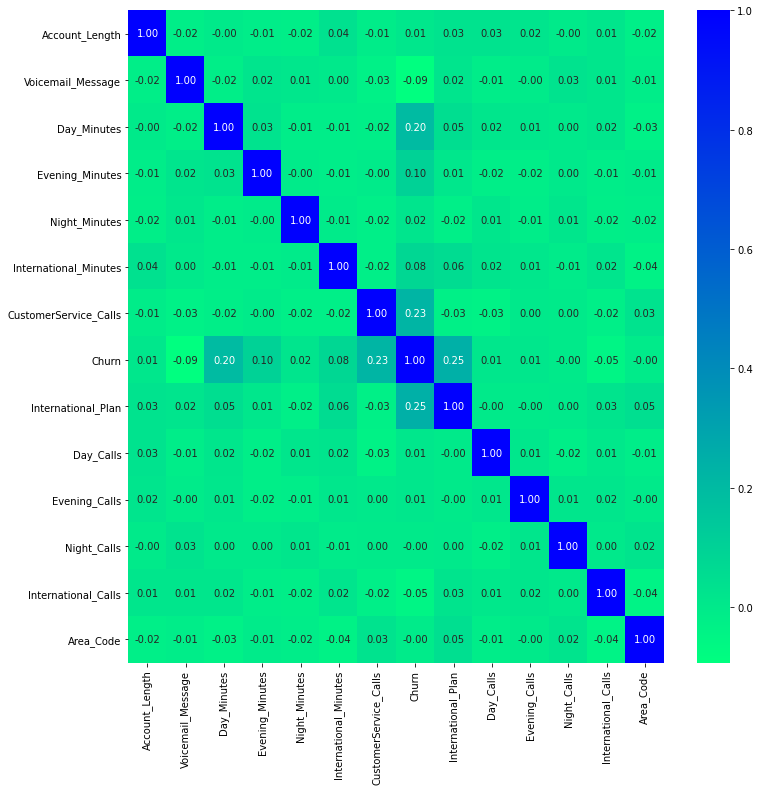

In [53]:
plt.figure(figsize=(12,12))
fig=sns.heatmap(df.corr(),annot=True, fmt='.2f',cmap='winter_r')
plt.show()

In [54]:
df_col=df.loc[:, (df.corr()['Churn'] > 0.19) | (df.corr()['Churn'] < -0.1)].columns
df_col

Index(['Day_Minutes', 'CustomerService_Calls', 'Churn', 'International_Plan'], dtype='object')

`Day_Minutes`, `CustomerService_Calls` and `International_Plan` are more positively correlated, while `International_Minutes` and `Evening_Minutes` are very slightly correlated to the target label

In [55]:
# sns.pairplot(df, hue ="Churn")

### Plot correlated features

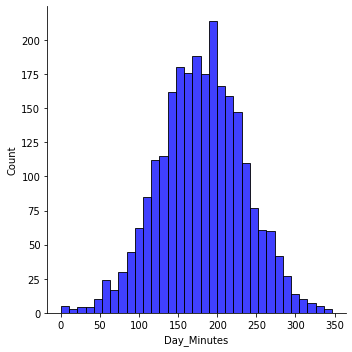

In [56]:
sns.displot(df.Day_Minutes, kde=False, color="b")

The `Day_Minutes` follows uniform distribution. The most talk time of  customers is 200-210 minutes.

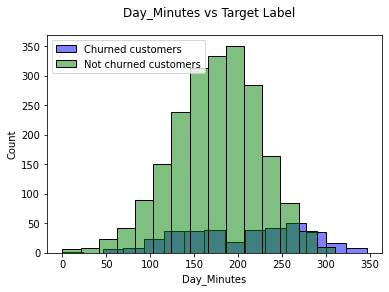

In [57]:
fig, ax = plt.subplots()

sns.histplot(data=df[df['Churn']==1], x="Day_Minutes", bins= 15, alpha=0.5, color="blue", label="Churned customers")
sns.histplot(data=df[df['Churn']==0], x="Day_Minutes", bins= 15, alpha=0.5, color="green", label="Not churned customers")
fig.suptitle("Day_Minutes vs Target Label")
ax.legend()

plt.show()

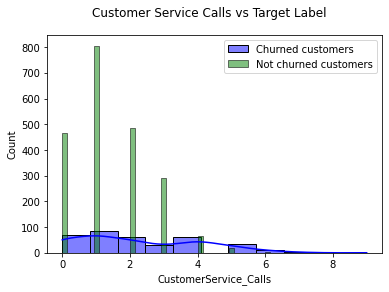

In [58]:
fig, ax = plt.subplots()

sns.histplot(data=df[df['Churn']==1], x="CustomerService_Calls", alpha=0.5, color="blue", label="Churned customers", kde=True)
sns.histplot(data=df[df['Churn']==0], x="CustomerService_Calls", alpha=0.5, color="green", label="Not churned customers")
fig.suptitle("Customer Service Calls vs Target Label")
ax.legend()

plt.show()

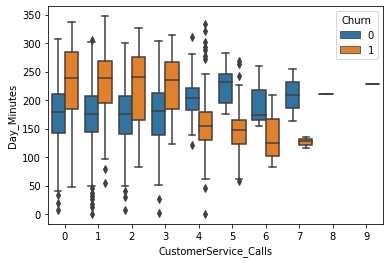

In [59]:
 sns.boxplot(x="CustomerService_Calls", y="Day_Minutes", hue="Churn",data=df)

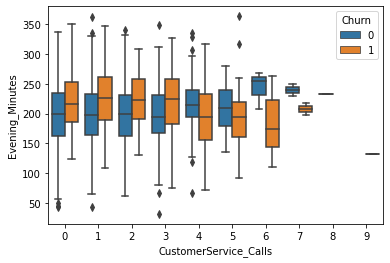

In [60]:
 sns.boxplot(x="CustomerService_Calls", y="Evening_Minutes", hue="Churn",data=df)

The boxplot shows that the churn customers who get more customer service calls have comparatively less talk time than churned customers who get less customer service calls. It is more prominent on morning calls than evening calls.

In [61]:
df_col=df.loc[:, (df.corr()['Churn'] > 0.19) | (df.corr()['Churn'] < -0.1)].columns
df_col

Index(['Day_Minutes', 'CustomerService_Calls', 'Churn', 'International_Plan'], dtype='object')

In [62]:
target = df['Churn']
df.drop(columns=['Churn'],inplace=True)

## Train Test Split

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, random_state = 0, stratify=target)

### Oversampling with SMOTE

In [65]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter =Counter(y_train)
print("Initially ",counter, 'target samples')

smte= SMOTE()
df_up, target_up=smte.fit_resample(X_train, y_train)

counter = Counter(target_up)
print("After oversampling", counter, 'target samples')

Initially  Counter({0: 1709, 1: 290}) target samples
After oversampling Counter({0: 1709, 1: 1709}) target samples


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [66]:
len(target_up)

3418

## Baseline Model

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix


models = {"log_reg":LogisticRegression(),
          "svm": SVC(),
          "g_nb": GaussianNB(),
          "knn": KNeighborsClassifier(),
          "dt":DecisionTreeClassifier(),
          "grad": GradientBoostingClassifier(),
          "bag":BaggingClassifier(base_estimator=DecisionTreeClassifier()),
          "rf": RandomForestClassifier(),
          "ab": AdaBoostClassifier(),
          "xgb": XGBClassifier()
          }

In [68]:
X_train, y_train = df_up, target_up

In [69]:
for mod, models in models.items():

  model_fit=models.fit(X_train, y_train)
  model_predict_y=models.predict(X_test.values)
  model_macro_f1_score= round(f1_score(y_test.values, model_predict_y, average='macro'), 3)

  print('Classification for ', mod,'\n', classification_report(y_test, model_predict_y, labels=None, target_names=None, sample_weight=None, digits=3, output_dict=False))
  print ("Macro f1 score: %.3f" % model_macro_f1_score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classification for  log_reg 
               precision    recall  f1-score   support

           0      0.936     0.720     0.814       428
           1      0.298     0.708     0.420        72

    accuracy                          0.718       500
   macro avg      0.617     0.714     0.617       500
weighted avg      0.844     0.718     0.757       500

Macro f1 score: 0.617
Classification for  svm 
               precision    recall  f1-score   support

           0      0.926     0.930     0.928       428
           1      0.571     0.556     0.563        72

    accuracy                          0.876       500
   macro avg      0.749     0.743     0.746       500
weighted avg      0.875     0.876     0.875       500

Macro f1 score: 0.746
Classification for  g_nb 
               precision    recall  f1-score   support

           0      0.939     0.829     0.881       428
           1      0.402     0.681     0.505        72

    accuracy                          0.808       500
 

The f1 score of `Bagging Classifier` is the highest with score 0.888. So, it is the final model.

### Final Model

Classification Report of best feature with Bagging
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       428
           1       0.83      0.72      0.77        72

    accuracy                           0.94       500
   macro avg       0.89      0.85      0.87       500
weighted avg       0.94      0.94      0.94       500



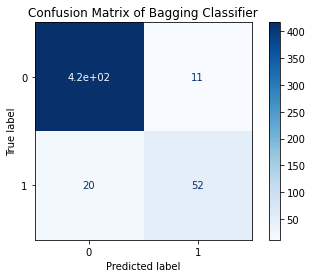

In [70]:
from sklearn.ensemble import BaggingClassifier

bagg=BaggingClassifier(random_state=1)
bagg.fit(X_train, y_train)
pred_y=bagg.predict(X_test)

final_f1=f1_score(y_test, pred_y)

print('Classification Report of best feature with Bagging')
print(classification_report(y_test,pred_y))

disp = plot_confusion_matrix(bagg, X_test, y_test,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix of Bagging Classifier")
plt.show()

### Save Model

In [71]:
import pickle

pickle.dump(bagg, open('model.pkl','wb'))

## Findings

1. Tree based classifier shows better prediction that other classifier. Here, the final prediction model is `Bagging Classifier`.
2. `Day_Minutes`, `CustomerService_Calls` and `International_Plan` are more positively correlated, while `International_Minutes` and `Evening_Minutes` are very slightly correlated to the target label. The feature importance in the experiment section below verifies it.

## Further Improvements

1. By adding more data, we can apply deep learning to improve the dataset.
2. The column `State` can be further explored to see the rate of churn in each state.

## Experiments

The code below was implemented as part of experiment.

Here, GridSearch was performed to find the best hyperparameter. Due to efficiency problem, the below implementation hasn't been used.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score, plot_confusion_matrix

In [ ]:
column_names=['Account_Length', 'Voicemail_Message', 'Day_Minutes', 'Evening_Minutes','Night_Minutes', 'International_Minutes', 'CustomerService_Calls','International_Plan', 'Day_Calls', 'Evening_Calls', 'Night_Calls','International_Calls', 'Area_Code']

In [ ]:
i=0
def grid_search_classifier(classifier_class, train_x,train_y,test_x,test_y,grid_params):

    metrics = make_scorer(f1_score, average = 'macro')
    clf = GridSearchCV(classifier_class(random_state=1),
                      grid_params, scoring = metrics)
    clf.fit(train_x,train_y)
    print('Best score: ', clf.best_score_,clf.best_params_)
    
    best_model = classifier_class(**clf.best_params_)
    best_model.fit(train_x, train_y)


    ## Feature Importances
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]   #gives the index of highest importances in descending order
    columns = column_names
    names=[columns[i] for i in indices]
    
    global i
    name_classifier=['Gradient Boosting Classifier', 'Random Forest Classifier','XGBoost Classifier']
    plt.title('Feature Importances of {}'.format(name_classifier[i]))
    plt.bar(range(X_train.shape[1]),importances[indices])
    plt.xticks(range(X_train.shape[1]),names,rotation=90)
    plt.xlabel('Important Features (From left to right)')
    plt.ylabel('Feature Values')
    plt.show()
    i=i+1
    
    df=pd.DataFrame({'Feature': names,'Importance': importances[indices]})
    print('The top five features and its importance:\n ',df.head())
    

    y_preds_final = best_model.predict(test_x)
    accuracy= round(f1_score(test_y,y_preds_final,average='macro'),3)
    return accuracy

In [ ]:
classifiers_grid = [
    (GradientBoostingClassifier,
    {'max_depth': [15, 9, 5]}
    ),
    (RandomForestClassifier,
    {'n_estimators': [30,50,100],'criterion':['gini','entropy']}
    ),
    (XGBClassifier,
    {'n_estimators': [20,50,100], 'max_depth': [15, 9, 5] }
    ),   
]

Best score:  0.9640148989898825 {'max_depth': 5}


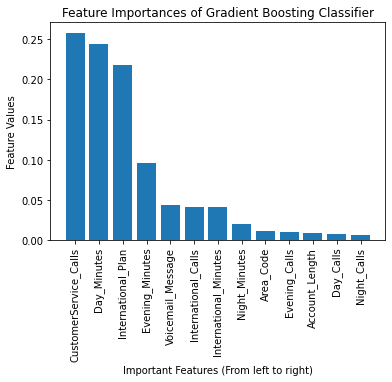

The top five features and its importance:
                   Feature  Importance
0  CustomerService_Calls    0.258490
1            Day_Minutes    0.244808
2     International_Plan    0.217806
3        Evening_Minutes    0.095451
4      Voicemail_Message    0.043433
Best score:  0.9552417473693181 {'criterion': 'entropy', 'n_estimators': 30}


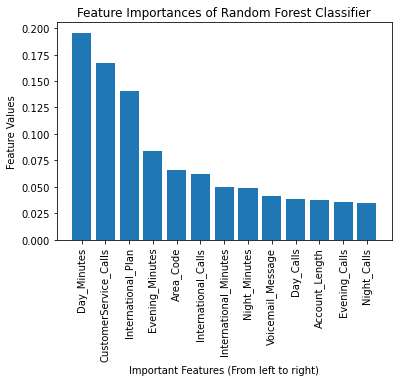

The top five features and its importance:
                   Feature  Importance
0            Day_Minutes    0.195794
1  CustomerService_Calls    0.166802
2     International_Plan    0.140766
3        Evening_Minutes    0.083817
4              Area_Code    0.065805
Best score:  0.9672381817135657 {'max_depth': 5, 'n_estimators': 100}


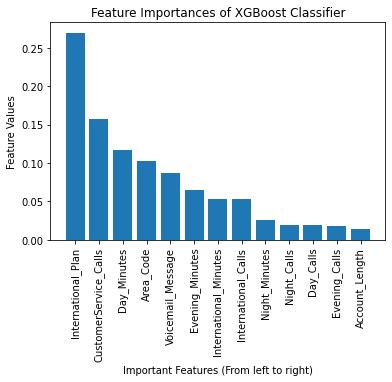

The top five features and its importance:
                   Feature  Importance
0     International_Plan    0.269738
1  CustomerService_Calls    0.156782
2            Day_Minutes    0.117167
3              Area_Code    0.102975
4      Voicemail_Message    0.086773


In [ ]:

accuracies=[]
for classifier, grid in classifiers_grid:
    accuracy = grid_search_classifier(classifier, X_train, y_train,X_test,y_test, grid)
    accuracies.append({'Classifier': (classifier),'f1_score':accuracy})
    
classwiseaccuracy = pd.DataFrame(accuracies)

The f1 score of XGBoost Classifier is 96%. So, the final model selected is XGBoost Classifier with hyperparameters `max_depth`=15 and `n_estimators`=100.


Macro f1_score:  0.968
              precision    recall  f1-score   support

           0      0.959     0.979     0.969       428
           1      0.978     0.958     0.968       427

    accuracy                          0.968       855
   macro avg      0.969     0.968     0.968       855
weighted avg      0.969     0.968     0.968       855



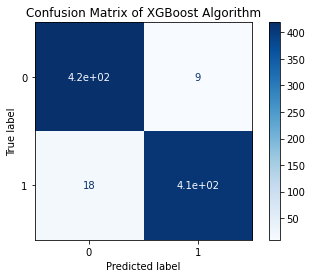

In [ ]:
model = XGBClassifier(max_depth=15,n_estimators=100)
model.fit(X_train,y_train)
predict_test = model.predict(X_test)

# F1 Score
macro_f1 = round(f1_score(y_test, predict_test,average='macro'),3)
print('\nMacro f1_score: ', macro_f1)

print (classification_report(y_test, predict_test, labels=None, target_names=None, sample_weight=None, digits=3, output_dict=False))

# Accuracy Score 
accuracy_test = accuracy_score(y_test,predict_test)

# Confusion matrix
disp = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix of XGBoost Algorithm")
plt.show()

